<a href="https://colab.research.google.com/github/SPThole/DL-Projects/blob/master/Image%20Captioning/Image_Captioning_with_resnet_LSTM_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset,random_split
import torch.optim as optim
from torchvision.models import resnet18
import zipfile


from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab,build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence,pad_packed_sequence,pack_padded_sequence
from tqdm import tqdm_notebook as tqdm1

from torchvision import transforms, utils
import os
# from google.colab.patches import cv2_imshow

from torchvision import models
import cv2
import skimage.io

%matplotlib inline

# Getting Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/flickr8k/captions.txt')

In [ ]:
df = df.groupby('image').tail(4).reset_index()

In [ ]:
df.shape

(32364, 3)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
I = np.load('/content/drive/MyDrive/images_for_caption.npz',allow_pickle=True)

In [ ]:
I = I['arr_0']

In [ ]:
I = np.repeat(I, 4, 0)

In [ ]:
class captdata(Dataset):

  def __init__(self,df,transform):

    self.df = df
    self.transform = transform

  def __getitem__(self,idx):

    caption = self.df.loc[idx,'caption']
    image = I[idx]
    # image = cv2.imread('../input/flickr8k/Images/'+df.loc[idx,'image'])

    if self.transform:
      image = self.transform(image)
    
    return image,caption

  def __len__(self):

    return len(self.df)

In [ ]:
def show_me_ex(im,l=None):
  if l:
    print(l)
  # print(im.shape)
  skimage.io.imshow(im.permute(1,2,0).numpy())
  return None

In [ ]:
transformation = transforms.Compose([
    
     transforms.ToPILImage(),
    transforms.Resize(226),                     
    transforms.RandomCrop(224),                 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [ ]:
dataset = captdata(df,transformation)

In [ ]:
im, l = dataset[166]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Two children play with a balloon in mud on a sunny day .


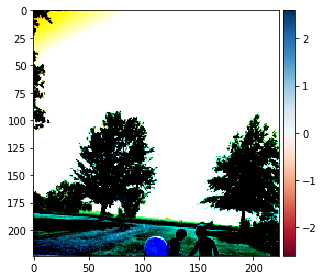

In [ ]:
show_me_ex(im,l)

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
# counter = Counter()
# for line in df['caption']:
#     counter.update(tokenizer(line))
# vocab = Vocab(counter, min_freq=2, specials=('<unk>', '<SOS>', '<EOS>', '<PAD>'))
# text_transform = lambda x: torch.tensor([vocab['<SOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']])

counter = Counter()
def itervocab(df):
  for line in df['caption']:  
      yield tokenizer(line)
vocab = build_vocab_from_iterator(itervocab(df), min_freq=2, specials=["<unk>", "<SOS>", "<EOS>", "<PAD>"])
vocab.set_default_index(vocab["<unk>"])
text_transform = lambda x: torch.tensor([vocab['<SOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']])

In [ ]:
vocab_size = len(vocab.get_stoi())

In [ ]:
train_dataset, test_dataset = random_split(dataset, [30000,2364])

In [ ]:
def collate_batch(batch):
  #  batch = batch.to(device)
   caption_train = []
   caption_test = []
   x_lens = []
   im = []
   for (img, caption) in batch:
        im.append(img)
        x_lens.append(torch.tensor(len(text_transform(caption))-1))
        caption_train.append(text_transform(caption)[:-1])
        caption_test.append(text_transform(caption)[1:])

   im = torch.stack(im)
   return im.to(device), pad_sequence(caption_train, padding_value=3.0,batch_first=True).to(device),\
          pad_sequence(caption_test, padding_value=3.0,batch_first=True).to(device)
          

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE,  
                              collate_fn=collate_batch,
                              num_workers = 0,
                              drop_last = True,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=BATCH_SIZE, 
                              collate_fn=collate_batch,
                             num_workers = 0,
                             drop_last = True)


# Training models

In [ ]:
class encoder(nn.Module):

  def __init__(self,
               batch_size):
    
    super(encoder, self).__init__()

    self.batch_size = batch_size


    model_res = models.resnet50(pretrained=True)
    # print(model_res)
    
    # self.fc = nn.Linear(self.hidden_size,self.output_size)

    # for param in model_res.parameters():
    #   param.requires_grad = False

    self.enc = nn.Sequential(*list(model_res.children())[:-2])
    
  def forward(self,im):
    

    out = self.enc(im)
    out = out.permute(0,2,3,1)
    # print('ENC OUT',out.shape)
    out = out.reshape(out.size(0),-1,out.size(-1))
    # print('ENC OUT',out.shape)

    return out


class attn(nn.Module):

  def __init__(self,
               encoder_out_size,
               decoder_hidden_size,
               decoder_input_size,
              attention_size):
    super(attn, self).__init__()

    self.enc_out = encoder_out_size
    self.dec_hid = decoder_hidden_size
    self.dec_in = decoder_input_size
    self.attention_size = attention_size

    self.U = nn.Linear(self.enc_out,self.attention_size)
    self.W = nn.Linear(self.dec_hid,self.attention_size)

    self.attn_f = nn.Linear(self.attention_size,1)


  def forward(self,enc_out,dec_hidn):

    # print('ATTENTION')
    
    # print('Enc out shape',enc_out.shape,'>>')
    encU = self.U(enc_out)
    # print('EncU',encU.shape)

    
    dec_hidn = dec_hidn
#     .permute(1,0,2)
    # print('dec_hidden shape',dec_hidn.shape,'>>')

    decW = self.W(dec_hidn).permute(1,0,2)
    # print('decW',decW.shape)

    # print(encU.shape,decW.shape)
    
#     print(encU,decW)

    UW = nn.functional.tanh(encU+decW)

    # print('UW',UW.shape,'>>')

    scores = nn.functional.softmax(self.attn_f(UW),dim=1)

#     print('scores',scores.shape,'>>')

    return scores


class decoderattn(nn.Module):

  def __init__(self,
               input_size,
               hidden_size,
               output_size,
               emb_size,
               attn):
    
    super(decoderattn, self).__init__()

    

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.emb_size = emb_size
    

    self.emb = nn.Embedding(self.input_size,self.emb_size)
    self.attn = attn

    self.rnn = nn.LSTM(input_size = self.emb_size + 2048,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       
                       batch_first = True)
    
    
    self.fc = nn.Linear(self.hidden_size,self.output_size)
    self.drop = nn.Dropout(0.1)

  def forward(self,enc_out,x,h0,c0):


    # print("DECODER")

#     print("ENC OUT,X",enc_out.shape,x.shape)

    a = self.attn(enc_out,h0)

#     print('scores',a.shape)
   

    context = a*enc_out
    # print('context',context.shape)
    context = context.sum(axis=1)
    # print('context',context.shape)

    # print('DECODER EMB INPUT',x.long().shape)

    x = self.emb(x.long())



    # print('DECODER EMBEDDED INPUT',x.shape,'>>')

    # print('DECODER CONCAT STEP',context.unsqueeze(1).shape,x.shape)
#     print(context)
    context_cat_lho = torch.cat((context,
                                 x),dim = 1)
    
    
    
    # print('context_cat_lho',context_cat_lho.shape)

    o,(h1,c1) = self.rnn(context_cat_lho.unsqueeze(1),(h0,c0))
    o = self.drop(self.fc(o))

#     print('OUTPUT',o.shape)

    return o,a,h1,c1

class myencdec(nn.Module):

  def __init__(self,enc,dec):
    super(myencdec, self).__init__()
    self.enc = enc
    self.dec = dec
    self.attn = attn


  def forward(self,X):

    h0 = torch.randn((1,self.enc.batch_size,self.dec.hidden_size)).to(device)
    c0 = torch.randn((1,self.enc.batch_size,self.dec.hidden_size)).to(device)

    # OUT = []
    # print('ITERATION ENCODER INPUT',X[0].shape,'>>')

    enc_out = self.enc(X[0])

    # print('ITERATION ENCODER OUTPUT',enc_out.shape,h0.shape,c0.shape,'>>')

    # print('ITERATION DECODER INPUT',enc_out.shape,X[1][:,0].shape,h0.shape,c0.shape,'>>')

    o,a,h1,c1 = self.dec(enc_out,X[1][:,0],h0,c0)

    # print('ITERATION DECODER INIT OUTPUT',o.shape)

    OUT = [o]
    
    for i in range(1,X[1].size(1)):

      # print(torch.argmax(o,axis=2).shape)

      o = o.squeeze(1)
      o = torch.argmax(o,axis=1)

      # print('ITERATION DEC',i,'th',o.shape)

      o,a,h1,c1 = self.dec(enc_out,
                      X[1][:,i],
                      h1,
                      c1)
      
      OUT.append(o)
      # print(o.shape)
    # print(torch.stack(OUT).shape)

    return torch.stack(OUT).permute(2,1,0,3).squeeze(0)
      
      

In [ ]:
#ENCODER 

enc = encoder(BATCH_SIZE)

# ATTENTION 
OUTPUT_SIZE = 2048
DECODER_INPUT_SIZE = vocab_size
DECODER_HIDDEN_SIZE = 1024
DECODER_EMB_SIZE = 1024
ATTN_SIZE = 512

att = attn(OUTPUT_SIZE,
           DECODER_HIDDEN_SIZE,
           DECODER_INPUT_SIZE,
           ATTN_SIZE)

# # DECODER 

dec = decoderattn(DECODER_INPUT_SIZE,
                  DECODER_HIDDEN_SIZE,
                  vocab_size,
                  DECODER_EMB_SIZE,
                  att)

model = myencdec(enc,dec).to(device)

# Testing shapes

In [ ]:

for loader in  train_dataloader:
  # print(im.shape)
  out = model(loader)
  break


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
out.shape

torch.Size([32, 21, 4747])

In [ ]:
for loader in  train_dataloader:
  # print(im.shape)
  # loader = [com.to(device) for com in loader]
  # loader = loader.to(device)
  out = model(loader)
  break


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr = 0.0001)
loss_func = nn.CrossEntropyLoss(ignore_index=vocab.get_stoi()["<PAD>"])

In [ ]:
device

device(type='cuda')

# Training

In [ ]:
class train_model:

  def __init__(self, 
               train_loader,
               test_loader,
               task,
               model,
               optimizer,
               criterion,
               epochs):
    
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.task = task
    self.optimizer = optimizer
    self.criterion = criterion
    self.epochs = epochs
    self.model = model

  

  def train_it(self):
    """
    """
    history = {'train_loss':[],
                 'test_loss':[],
                 'train_score':[],
                 'test_score':[]}
    for epoch in range(self.epochs):
      self.model.train()

      for loader in tqdm1(self.train_loader):

        self.optimizer.zero_grad()

        im, xs, ys = loader
        # ys = torch.tensor(xs[2]).reshape(-1,)
        
        preds= self.predict(loader)
        # print(preds.shape,ys.shape)
        loss = self.criterion(preds.reshape(-1,vocab_size),ys.reshape(-1,).long())

        loss.backward()
        self.optimizer.step()
        
      self.model.eval()

      

      if epoch%1==0:
        print(f"Iteration : {epoch}")
        torch.save(model.state_dict(), '/content/drive/MyDrive/model_pregrad.pth')

        # history['train_loss'].append(self.calc_loss(self.train_loader))
        history['test_loss'].append(self.calc_loss(self.test_loader))
        # history['train_score'].append(self.calc_score(self.train_loader))
        # history['test_score'].append(self.calc_score(self.test_loader))
        
        fig = plt.figure(figsize = (12,7))
        plt.subplot(1, 2, 1)
        # plt.plot(history['train_loss'], color = 'red', label = 'Training Loss')
        plt.plot(history['test_loss'], color = 'green', label = 'Validation Loss')
        plt.legend()
        

        # plt.subplot(1, 2, 2)
        # plt.plot(history['train_score'], color = 'red', label = 'Training Score')
        # plt.plot(history['test_score'], color = 'green', label = 'Validation Score' )
        # plt.legend()
        plt.show()
        

        # fig = plt.figure()
        # ax = fig.add_subplot(111, projection = '3d')
        # ax.scatter(X[:,0], X[:,1], model(torch.tensor(X).float())[:,0].detach().numpy())
        # plt.show()
    return self.model, history

  def r2(self, xs, ys):
    return r2_score(ys.reshape(-1,), self.predict(xs).numpy())
 
  def acc(self, ys, preds):
    maxs, cls = torch.max(preds, axis = 1)
    
    return torch.sum(cls==ys.reshape(-1,)).item()/ys.shape[0]

  def predict(self,xs):
    return self.model(xs)

  def calc_loss(self,loader):
    loss = []
    for idx, loader in enumerate(loader):
       _, _, ys = loader
       loss.append(self.criterion(self.predict(loader).reshape(-1,vocab_size),ys.reshape(-1,).long()).item())
    return np.mean(loss)
 
  def calc_score(self,loader):
    scores = []
    for data in loader:
      _, _, ys = data
      if self.task == 'reg':
          
          scores.append(self.r2(ys,self.predict(data).reshape(-1,vocab_size)))
          
      else:
          scores.append(self.acc(ys.reshape(-1,),self.predict(data).reshape(-1,vocab_size)))
    return np.mean(scores)

In [ ]:
468*64

29952

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



Iteration : 0


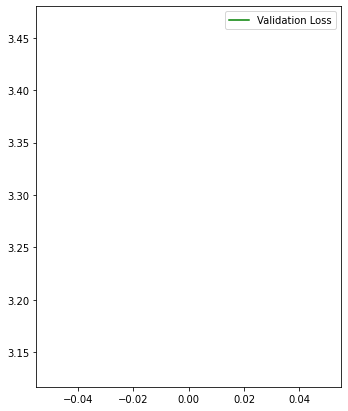


Iteration : 1


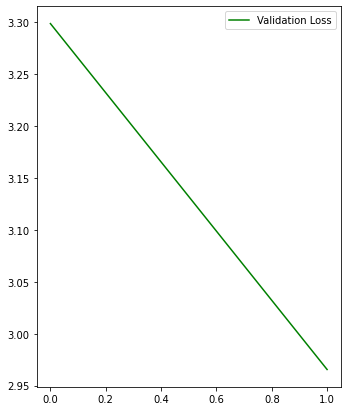


Iteration : 2


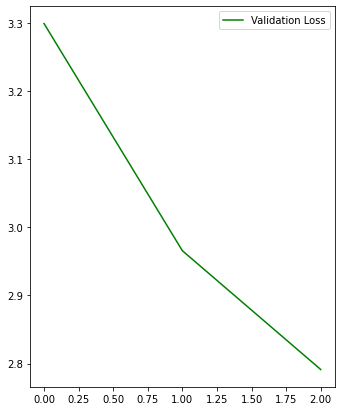


Iteration : 3


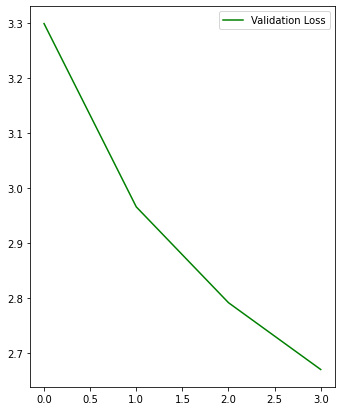


Iteration : 4


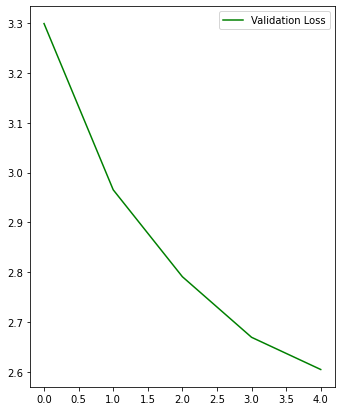


Iteration : 5


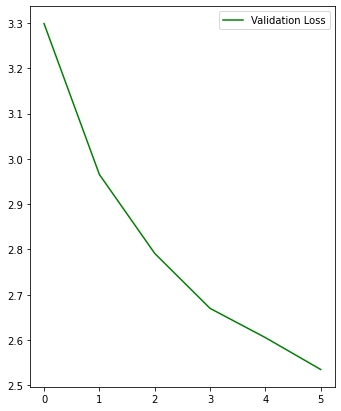

In [ ]:
trainer = train_model(train_dataloader,
                      test_dataloader,
                      'clf',
                      model,
                      optimizer,
                      loss_func,
                      6)
model, h = trainer.train_it()

# Testing/inference

In [ ]:
# ## MIGHT BE USED TO TEST 

# # torch.save(model.state_dict(), '/content/drive/MyDrive/captioner3.pth')
# model.load_state_dict(torch.load('/content/drive/MyDrive/model2.pth',map_location=device))
model = trainer.model
model.eval()


# for X in test_dataloader:
#   out = model(X)
#   for idx in np.random.randint(0,16,5):
#     # idx = 1
#     print(idx)
#     show_me_ex(X[0][idx].to('cpu'),' '.join([vocab.itos[k] for k in X[1][idx]]))
#     plt.show()
#     print('PREDICTED')
#     print(' '.join([vocab.itos[k] for k in torch.argmax(out[idx],axis=1)]))


  

myencdec(
  (enc): encoder(
    (enc): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (downsa

In [ ]:
device ='cpu'
model= model.to(device)
model.eval()

myencdec(
  (enc): encoder(
    (enc): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (downsa

In [ ]:
l = os.listdir('/content/')
l = [k for k in l if 'jpg' in k]
pd.options.display.max_colwidth = 100

In [ ]:
def plot_attention(image, result, attention_plot):
   temp_image = image
   fig = plt.figure(figsize=(100, 100))
   len_result = len(result)
   for l in range(15):
       temp_att = np.resize(attention_plot[l].detach().numpy(), (7, 7))
       
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l],fontsize=60)
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.8, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [ ]:

def infer(path,list_of_files,max_length,num_ex):
  
  for imagr in list_of_files:
    d = {'pred':[],'score':[]}
    im1 = cv2.imread(path+imagr)
    skimage.io.imshow(im1)
    plt.show()
    im = transformation(im1)
    im = model.enc(im.unsqueeze(0).to(device))
    for rr in range(num_ex):
      h0 = torch.randn((1,1,model.dec.hidden_size)).to(device)
      c0 = torch.randn((1,1,model.dec.hidden_size)).to(device)
      out = torch.tensor([[1.]]).to(device)

      O = [1]
      A = []
      S = [1]
      for i in range(max_length):
        
        if torch.argmax(out,axis=1).detach().item()!=2 and i!=0:
          # print(out)
          out,a, h1,c1 = model.dec(im,out.squeeze(0),h0,c0)
          h0,c0 = h1,c1

          O.append(torch.argmax(out[0],axis=1).detach().item())
          s1,_ = torch.max(torch.softmax(out[0],dim=1),axis=1)
          S.append(s1.detach().numpy())
          A.append(a)
    
          out = torch.argmax(out[0],axis=1).unsqueeze(0)
        if torch.argmax(out,axis=1).detach().item()==2:
          break
      plot_attention(im1,[vocab.get_itos()[k] for k in O][1:],A)

      d['pred'].append(' '.join([vocab.get_itos()[k] for k in O]))
      d['score'].append(np.prod(S))
    print(pd.DataFrame(d).sort_values(by='score',ascending=False).loc[0,:])
      
  

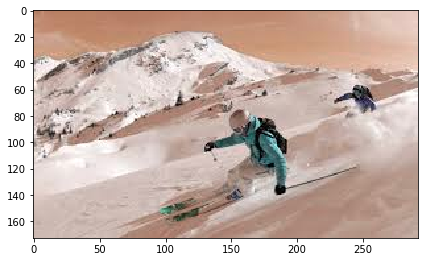

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


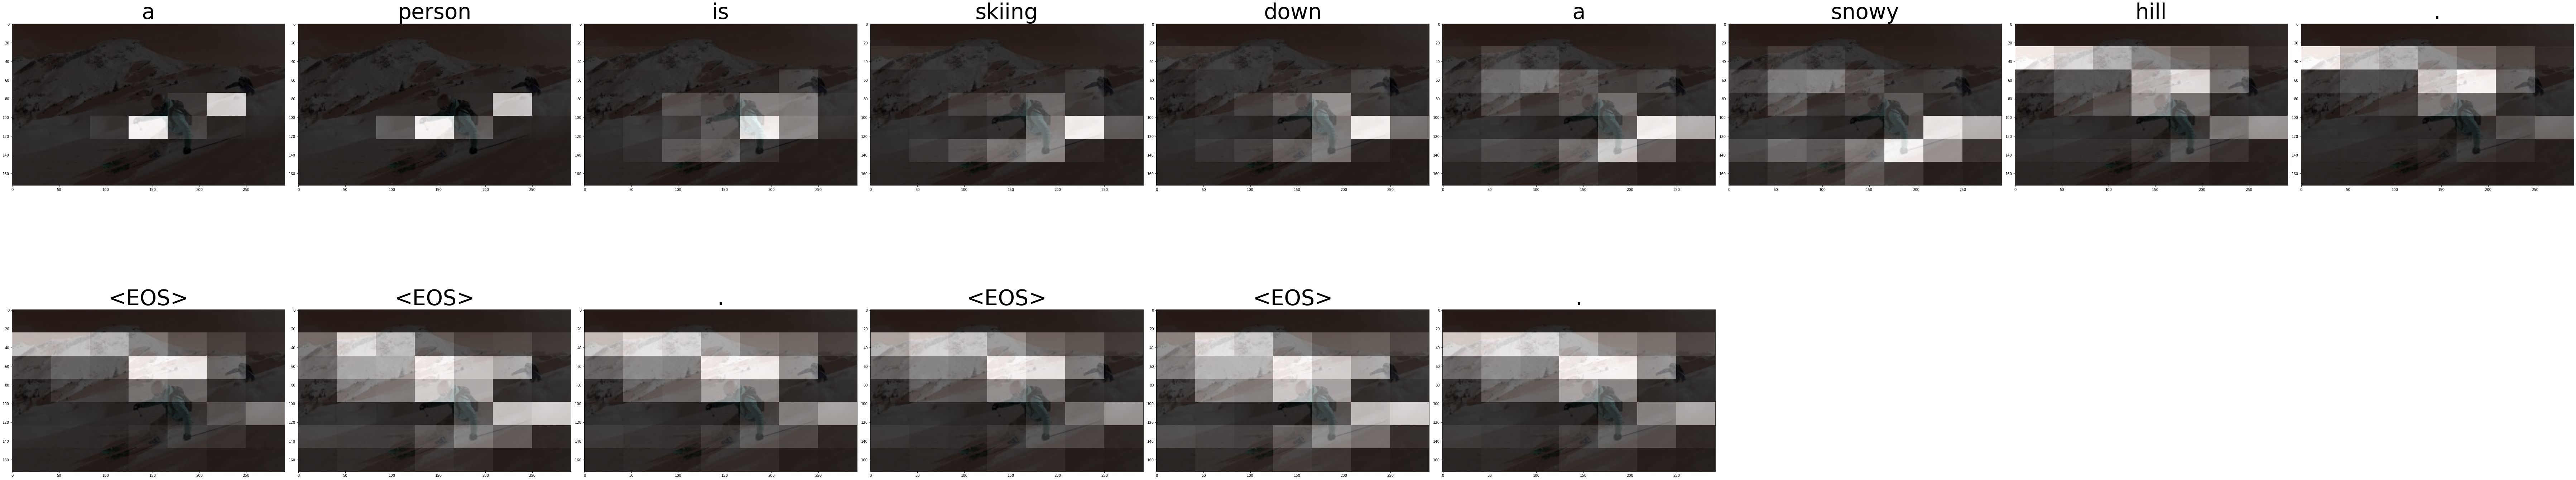

pred     <SOS> a person is skiing down a snowy hill . <EOS> <EOS> . <EOS> <EOS> . <EOS> <EOS> . <EOS>
score                                                                                 [1.8191306e-05]
Name: 0, dtype: object


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
infer('/content/',l,20,1)